In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model, metrics
import statsmodels.api as sm
from scipy import stats

colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']


%matplotlib inline

# ECON323 Final Project: Russian Language and Trade

### The Purpose of the Project

In my project I will study the effect of Russian language on trade between former Soviet Republics and members of the Eastern Bloc. I would like to see if the percentage of population that speaks Russian affects volumes of bilateral trade flows, using the gravity model of trade. I downloaded my trade data which is taken from the CEPII website and added language data taken from Ethnologue.  

Firstly, importing, cleaning, and preparing the dataset: 

In [163]:
df = pd.read_csv("gravity.csv")  
gravity = df[['year','iso3_o','iso3_d', 'iso3num_o', 'iso3num_d', 'dist', 'comlang_off', 'comrelig', 'comleg_posttrans', 'pop_o', 'pop_d', 'gdp_o', 'gdp_d', 'rta', 'tradeflow_baci', 'rus_o', 'rus_d']]
gravity = gravity.drop(gravity[gravity.iso3_o==gravity.iso3_d].index)
gravity['logtrade'] = np.log10(gravity['tradeflow_baci'])
gravity['logdist'] = np.log10(gravity['dist'])
gravity['loggdp_o'] = np.log10(gravity['gdp_o'])
gravity['loggdp_d'] = np.log10(gravity['gdp_d'])
gravity['logrus_o'] = np.log10(gravity['rus_o'])
gravity['logrus_d'] = np.log10(gravity['rus_d'])
gravity=gravity.dropna()
gravity.head()

,year,iso3_o,iso3_d,iso3num_o,iso3num_d,dist,comlang_off,comrelig,comleg_posttrans,pop_o,...,rta,tradeflow_baci,rus_o,rus_d,logtrade,logdist,loggdp_o,loggdp_d,logrus_o,logrus_d
24,2001,ALB,ARM,8,51,2077.855,0,0.0,1,3064.111,...,0,0.708,0.005,0.55942,-0.149967,3.317615,6.611832,6.326022,-2.30103,-0.252262
25,2002,ALB,ARM,8,51,2077.855,0,0.0,1,3051.427,...,0,1.431,0.005,0.55942,0.155640,3.317615,6.648299,6.375908,-2.30103,-0.252262
28,2005,ALB,ARM,8,51,2077.855,0,0.0,1,2992.724,...,0,0.584,0.005,0.55942,-0.233587,3.317615,6.923062,6.690235,-2.30103,-0.252262
29,2006,ALB,ARM,8,51,2077.855,0,0.0,1,2968.028,...,0,0.739,0.005,0.55942,-0.131356,3.317615,6.960592,6.805124,-2.30103,-0.252262
30,2007,ALB,ARM,8,51,2077.855,0,0.0,1,2940.880,...,0,0.096,0.005,0.55942,-1.017729,3.317615,7.029425,6.964085,-2.30103,-0.252262


### Countries

In the following map you can see what countries I am focusing on. You can also click on a country and see the proportion of its population that speaks Russian. It might take some time to load


In [164]:
gravity2 = gravity

from geopy.geocoders import Nominatim
import pycountry

geolocator = Nominatim(user_agent="jinxkey@gmail.com")
def geolocate(country):
    if country!="Georgia": 
        try:
            loc = geolocator.geocode(country)
            return (loc.latitude, loc.longitude)
        except:
            return np.nan
    else: 
        return (41.716667, 44.783333)

gravity2["Names"] = gravity['iso3_o'].apply(lambda x: pycountry.countries.get(alpha_3=x).name)
gravity2 = gravity2[["Names", "rus_o"]]
gravity2 = gravity2.drop_duplicates()
gravity2["Coordinates"] = gravity2['Names'].apply(lambda x: geolocate(x))
gravity2.head()

,Names,rus_o,Coordinates
24,Albania,0.005000,"(41.000028, 19.9999619)"
419,Armenia,0.559420,"(40.7696272, 44.6736646)"
831,Azerbaijan,0.525184,"(40.3936294, 47.7872508)"
1243,Bulgaria,0.272000,"(42.6073975, 25.4856617)"
1659,Belarus,0.737282,"(53.4250605, 27.6971358)"


In [165]:
gravity2[['Latitude', 'Longitude']] = pd.DataFrame(gravity2['Coordinates'].tolist(), index=gravity2.index)
import folium
from folium.plugins import MarkerCluster

world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)

for i in range(len(gravity2)):
        lat = gravity2.iloc[i]['Latitude']
        long = gravity2.iloc[i]['Longitude']
        radius=5
        popup_text = """Country : {}<br>
                    %of Russian Speakers : {}<br>"""
        popup_text = popup_text.format(gravity2.iloc[i]['Names'],
                                   gravity2.iloc[i]['rus_o']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
        
world_map

### Basic Gravity Model

I will use the gravity model of trade for my analysis. It states that trade (T) should increase with economy sizes (GDPs) and decrease with distance (D). The general formula for any two countries i and j: 
$$
  T_{ij} = \frac{GDP_i * GDP_j}{D_{ij}}
$$

The main prediction of the model can be tested using our data. 

Basic gravity model: log(Trade Flows) = -3.6248 + 0.8398 log(Product of GDPs) -1.4177 log(Distance)


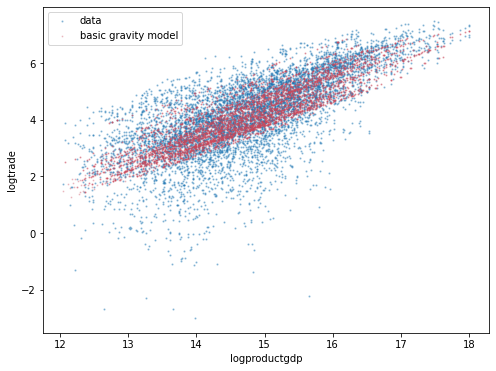

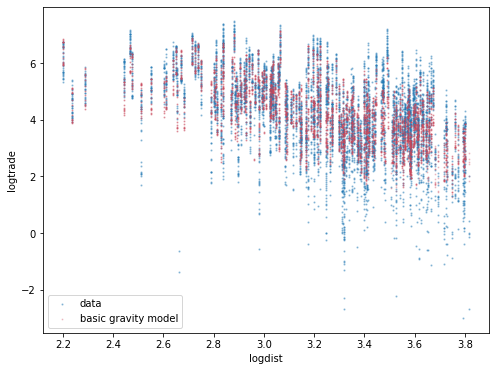

In [166]:
gravity["logproductgdp"] = gravity['loggdp_o'] + gravity['loggdp_d']
X = gravity[['logproductgdp', 'logdist']]
y = gravity['logtrade']

lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

beta_0 = lr_model.intercept_
beta_1 = lr_model.coef_[0]
beta_2 = lr_model.coef_[1]

def var_scatter(df, ax=None, var="logproductgdp"):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y="logtrade", alpha=0.35, s=1.5, ax=ax)

    return ax

ax = var_scatter(gravity)

def scatter_model(mod, X, ax=None, color=colors[1], x="logproductgdp"):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X[x], mod.predict(X), c=color, alpha=0.25, s=1)
    return ax


scatter_model(lr_model, X, ax, color=colors[1])
ax.legend(["data", "basic gravity model"])

def var_scatter(df, ax=None, var="logdist"):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y="logtrade", alpha=0.35, s=1.5, ax=ax)

    return ax

ax = var_scatter(gravity)

def scatter_model(mod, X, ax=None, color=colors[1], x="logdist"):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X[x], mod.predict(X), c=color, alpha=0.25, s=1)
    return ax


scatter_model(lr_model, X, ax, color=colors[1])
ax.legend(["data", "basic gravity model"])



print(f"Basic gravity model: log(Trade Flows) = {beta_0:.4f} + {beta_1:.4f} log(Product of GDPs) {beta_2: .4f} log(Distance)")


As can be seen from the coefficients and scatter plots, gravity equation more or less correctly predicts the volume of trade between two countries: trade increases with GDPs and decreases with distance. We checked that the data is consistent with other studies employing gravity equation. 

### Full Gravity Model (Multivariate Regression)

Now we can employ the full gravity model which will include the variable for the proportion of population that speaks Russian (logrus_o - in the origin country and logrus_d - in the destination country) while controlling for common religion (comrelig index), common legal systems (comleg_posttrans), and regional trade agreements (rta). 

In [167]:
X = gravity[['loggdp_o', 'loggdp_d', 'logdist', 'logrus_o', 'logrus_d', 'comrelig', 'comleg_posttrans', 'rta']]
y = gravity['logtrade']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())



/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:               logtrade   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2049.
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:21:28   Log-Likelihood:                -7965.5
No. Observations:                6931   AIC:                         1.595e+04
Df Residuals:                    6922   BIC:                         1.601e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.0769      0.187  

From the regression, a 4.6% increase in the proportion of Russian speakers in the exporter country increases trade flows by 10%. A 3.1% increase in the importer increases it by 10%. We can also see that the results are statistically significant.

### Panel Regression with Fixed Effects
Since the data is panel across years, it makes sense to conduct a panel regression with time-fixed effects.

In [168]:
dataset = pd.read_csv('gravity.csv', usecols = ['year', 'iso3_o', 'iso3_d', 'dist', 'comrelig', 'comleg_posttrans', 'gdp_o', 'gdp_d', 'rta', 'tradeflow_baci', 'rus_o', 'rus_d'],\
 index_col = ['iso3_o','year'])
years = dataset.index.get_level_values('year').to_list()
dataset['year'] = pd.Categorical(years)
dataset=dataset.dropna()
dataset['logtrade'] = np.log10(dataset['tradeflow_baci'])
dataset['logdist'] = np.log10(dataset['dist'])
dataset['loggdp_o'] = np.log10(dataset['gdp_o'])
dataset['loggdp_d'] = np.log10(dataset['gdp_d'])
dataset['logrus_o'] = np.log10(dataset['rus_o'])
dataset['logrus_d'] = np.log10(dataset['rus_d'])

In [169]:
from linearmodels import PanelOLS

mod = PanelOLS.from_formula("logtrade ~ loggdp_o+loggdp_d+logdist+logrus_o+logrus_d+comrelig+comleg_posttrans+rta+TimeEffects",
                            data=dataset)

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]


,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
comleg_posttrans,-0.1057,0.0694,-1.5236,0.1277,-0.2417,0.0303
comrelig,0.3363,0.2187,1.5382,0.1240,-0.0923,0.7650
logdist,-1.2436,0.1061,-11.719,0.0000,-1.4516,-1.0356
loggdp_d,0.8104,0.0486,16.669,0.0000,0.7151,0.9057
loggdp_o,1.2514,0.0954,13.111,0.0000,1.0643,1.4385
logrus_d,0.3245,0.0539,6.0199,0.0000,0.2189,0.4302
logrus_o,0.4746,0.1426,3.3277,0.0009,0.1950,0.7542
rta,0.3528,0.0612,5.7665,0.0000,0.2329,0.4727


With time fixed effects, the coefficients do not change much from the multivariate regression from above. 

### Lasso Regression

In [170]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

lasso_model = linear_model.Lasso()
lasso_model.fit(X, y)

lasso_coefs = pd.Series(dict(zip(list(X), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(X), lr_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
loggdp_o,0.0,1.109562
loggdp_d,0.0,0.669635
logdist,-0.0,-1.397919
logrus_o,0.0,0.460435
logrus_d,0.0,0.313060
comrelig,0.0,0.278484
comleg_posttrans,0.0,-0.098778
rta,0.0,0.267906


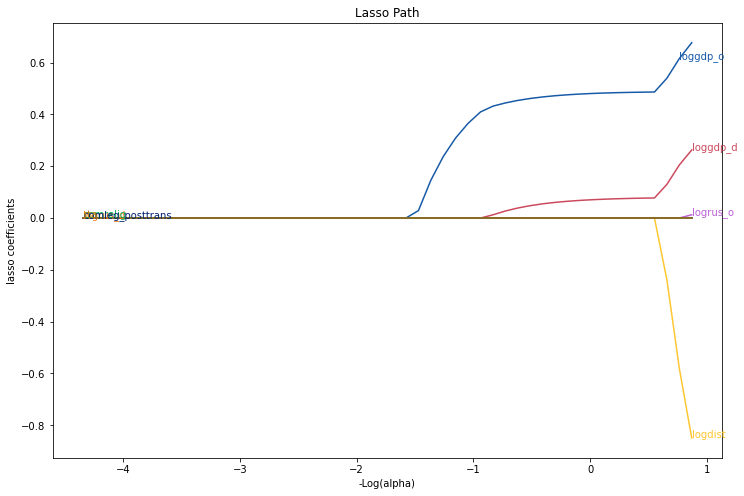

In [32]:
from itertools import cycle
alphas = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(X, y, alphas=alphas, fit_intercept=True, max_iter=10000)

fig, ax = plt.subplots(figsize=(12, 8))
color_cycle = cycle(colors)
log_alphas = -np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, color_cycle, list(X)):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)

In [55]:
X_train = X.iloc[:50, :]
X_test = X.iloc[50:, :]
y_train = y.iloc[:50]
y_test = y.iloc[50:]

lasso = linear_model.LassoCV(cv=6).fit(X_train,y_train)

print(f"Lasso training MSE = {metrics.mean_squared_error(y_train,lasso.predict(X_train))}, R2={1-metrics.mean_squared_error(y_train,lasso.predict(X_train))/y_train.var()}")
print(f"Lasso testing MSE  = {metrics.mean_squared_error(y_test,lasso.predict(X_test))}")
alpha=-np.log10(lasso.alpha_)
print(alpha)

Lasso training MSE = 0.5512535723721111, R2=0.6646361321788408
Lasso testing MSE  = 4.747276965160379
2.048646811314795


There is evidence that the model is overfitting. $ \lambda $ must be large. 

Code sources used: 

https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10

https://stackoverflow.com/questions/29550414/how-can-i-split-a-column-of-tuples-in-a-pandas-dataframe

https://datascience.quantecon.org/applications/regression.html#linear-regression

https://datascience.quantecon.org/applications/regression.html#lasso-regression

https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

https://matheusfacure.github.io/python-causality-handbook/13-Panel-Data-and-Fixed-Effects.html

Solution to problem set 7
